In [1]:
import pandas as pd
import pyrsm as rsm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tuango = pd.read_pickle("data/tuango.pkl")
tuango.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27878 entries, 0 to 27877
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   userid      27878 non-null  object  
 1   recency     27878 non-null  int32   
 2   frequency   27878 non-null  int32   
 3   monetary    27878 non-null  float64 
 4   rfm_iq_pre  27878 non-null  object  
 5   buyer       27878 non-null  category
 6   ordersize   27878 non-null  float64 
 7   platform    27878 non-null  category
 8   category    27878 non-null  int32   
 9   mobile_os   27878 non-null  category
dtypes: category(3), float64(2), int32(3), object(2)
memory usage: 1.2+ MB


In [3]:
# 对推送有响应的顾客比例
np.mean(tuango.buyer=='yes')

0.02980845110840089

In [4]:
# 推送带来的平均订单金额
np.mean(tuango[tuango.buyer=='yes']['ordersize'])

202.12876052948255

In [5]:
# 划分独立 RFM 区间
# 其中 R最近购买时间，最近的一组标记为 1，F频率和 M金额都是最大的一组标记为 1
tuango = tuango.assign(rec_iq=rsm.xtile(tuango["recency"], 5))
tuango = tuango.assign(freq_iq=rsm.xtile(tuango["frequency"], 5, rev=True))
tuango = tuango.assign(mon_iq=rsm.xtile(tuango["monetary"], 5, rev=True))
tuango.head()

,userid,recency,frequency,monetary,rfm_iq_pre,buyer,ordersize,platform,category,mobile_os,rec_iq,freq_iq,mon_iq
0,U12617430,309,7,39.8,514,no,0.0,App,3,android,5,1,4
1,U63302737,297,8,39.8,514,no,0.0,Browser,3,android,5,1,4
2,U77095928,295,1,72.9,553,no,0.0,Browser,3,android,5,5,3
3,U43509181,277,1,40.0,554,no,0.0,Browser,3,android,5,5,4
4,U23195941,259,1,21.0,555,no,0.0,App,3,android,5,5,5


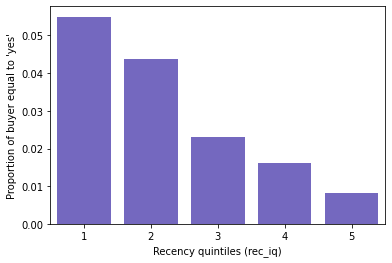

In [6]:
# 最近购买时间越近，响应推送的顾客比例越高。

fig_rec = rsm.prop_plot(tuango, "rec_iq", "buyer", "yes")
fig_rec = fig_rec.set(xlabel="Recency quintiles (rec_iq)")

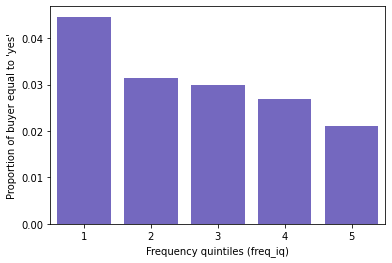

In [7]:
# 购买频率越高，响应比例越高。

fig_freq = rsm.prop_plot(tuango, "freq_iq", "buyer", "yes")
fig_freq = fig_freq.set(xlabel="Frequency quintiles (freq_iq)")

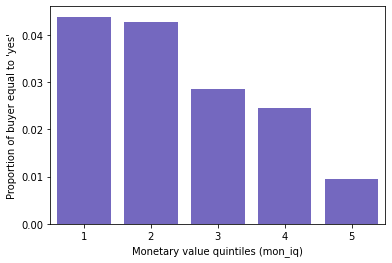

In [8]:
# 订单金额越大，响应比例越高。

fig_mon = rsm.prop_plot(tuango, "mon_iq", "buyer", "yes")
fig_mon = fig_mon.set_xlabel("Monetary value quintiles (mon_iq)")

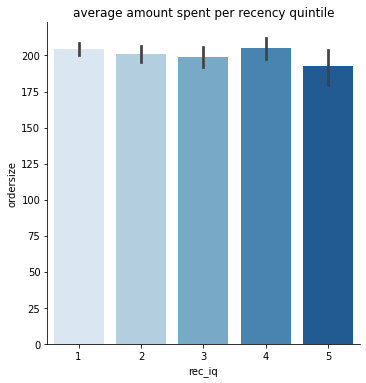

In [9]:
sns.catplot(x='rec_iq',y='ordersize',data=tuango[tuango.buyer=='yes'],
            kind='bar',palette="Blues").set(title='average amount spent per recency quintile')
plt.show()

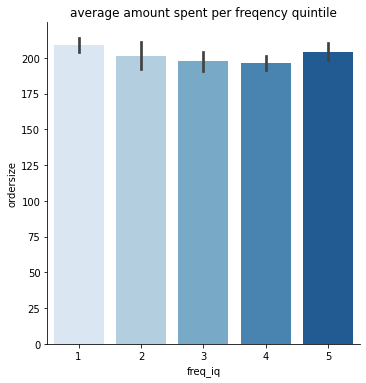

In [10]:
sns.catplot(x='freq_iq',y='ordersize',data=tuango[tuango.buyer=='yes'],
            kind='bar',palette="Blues").set(title='average amount spent per freqency quintile')
plt.show()

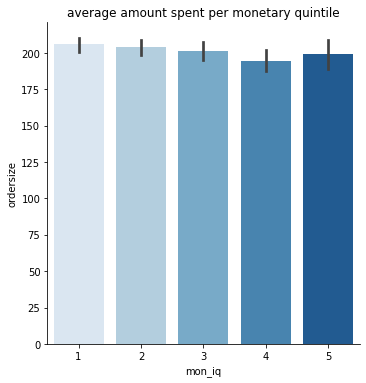

In [11]:
sns.catplot(x='mon_iq',y='ordersize',data=tuango[tuango.buyer=='yes'],
            kind='bar',palette="Blues").set(title='average amount spent per monetary quintile')
plt.show()

响应的可能性因五分之一而异，并且与五分之一呈正相关。
五分位的订单大小基本相同。

In [12]:
# 生成独立 RFM 的三位号码
tuango = tuango.assign(
    rfm_iq=tuango["rec_iq"].astype(str)
    + tuango["freq_iq"].astype(str)
    + tuango["mon_iq"].astype(str)
)

In [13]:
# 顺序 RFM。按照 R，F，M 的顺序依次创建区间。

tuango = tuango.assign(
    freq_sq=tuango.groupby("rec_iq")["frequency"].transform(rsm.xtile, 5, rev=True)
)

tuango = tuango.assign(
    mon_sq=tuango.groupby(["rec_iq", "freq_sq"])["monetary"].transform(rsm.xtile, 5, rev=True)
)

# 生成顺序 RFM 的三位号码
tuango = tuango.assign(
    rfm_sq=tuango["rec_iq"].astype(str)
    + tuango["freq_sq"].astype(str)
    + tuango["mon_sq"].astype(str)
)

tuango.head()

,userid,recency,frequency,monetary,rfm_iq_pre,buyer,ordersize,platform,category,mobile_os,rec_iq,freq_iq,mon_iq,rfm_iq,freq_sq,mon_sq,rfm_sq
0,U12617430,309,7,39.8,514,no,0.0,App,3,android,5,1,4,514,1,4,514
1,U63302737,297,8,39.8,514,no,0.0,Browser,3,android,5,1,4,514,1,4,514
2,U77095928,295,1,72.9,553,no,0.0,Browser,3,android,5,5,3,553,5,3,553
3,U43509181,277,1,40.0,554,no,0.0,Browser,3,android,5,5,4,554,5,4,554
4,U23195941,259,1,21.0,555,no,0.0,App,3,android,5,5,5,555,5,5,555


### What is the breakeven response rate?

In [14]:
# 假设提供交易的边际成本为2.5元。每笔交易的费用为销售收入的50％。
# 202.13元 为推送带来的平均订单金额。那么需要响应率至少达到 0.024720656580638784 才能盈利。
breakeven = 2.5 / (202.13 - 101)
breakeven

0.024720656580638784

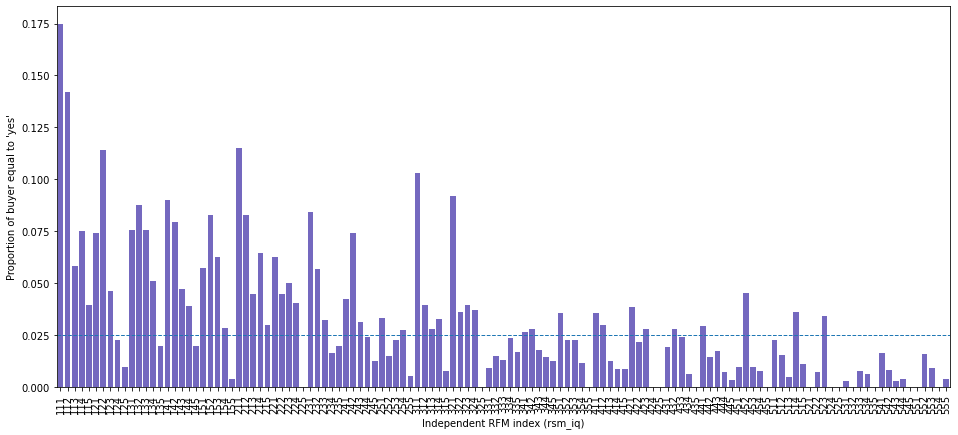

In [15]:
# plot all 125 groups
plt.figure(figsize=(16, 7))
fig = rsm.prop_plot(tuango, "rfm_iq", "buyer", "yes", breakeven=breakeven)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig = fig.set(xlabel="Independent RFM index (rsm_iq)")

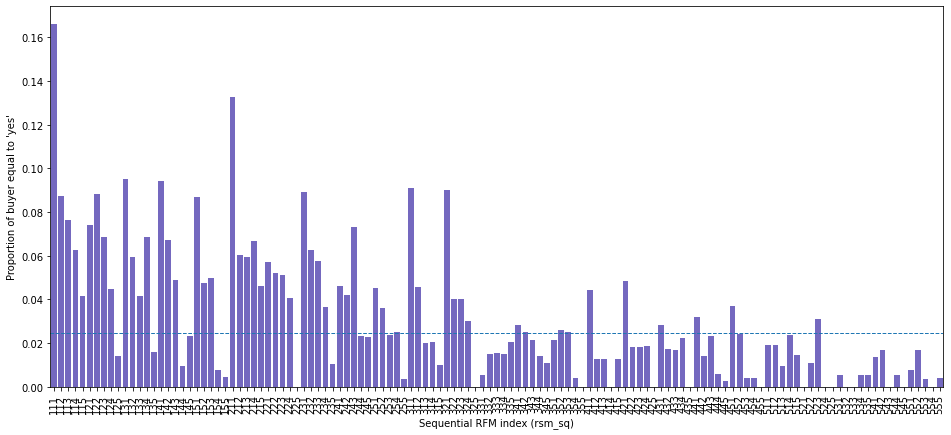

In [16]:
# plot all 125 groups
plt.figure(figsize=(16, 7))
fig = rsm.prop_plot(tuango, "rfm_sq", "buyer", "yes", breakeven=breakeven)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
fig = fig.set(xlabel="Sequential RFM index (rsm_sq)")

## 给所有用户发推送

In [38]:
def performance(df=tuango, mail_to=None, intro=None, perf='buyer', lev='yes'):
    
    if mail_to:
        perc_mail = np.nanmean(df[mail_to]) # 推送比例
        df = df[df[mail_to]]
    else:
        perc_mail = 1.0 # 推送比例
        
    nr_mail = 250902 * perc_mail  # 推送数量
    mail_cost = 2.5 * nr_mail    # 推送成本

    rep_rate = np.nanmean(df[perf]==lev) # 响应比例
    nr_resp = nr_mail * rep_rate  # 响应数量

    revenue = 202.13 * nr_resp
    profit = 0.5 * revenue - mail_cost
    ROME = profit / mail_cost
    
    print(
    f"""推送数量及比例为 {int(nr_mail*perc_mail):,} ({round((100 * perc_mail), 2)}%) 名顾客
预计响应率为 {round((100 * rep_rate), 2)}%
预计收入为 ${int(revenue):,} ，预计成本为 ${int(mail_cost):,} 
预计利润为 ${int(profit):,}
营销费用回报率 ROME 为 {round((100 * ROME), 2)}%"""
)
    return [profit, ROME]

no_target = performance()

推送数量及比例为 250,902 (100.0%) 名顾客
预计响应率为 2.98%
预计收入为 $1,511,730 ，预计成本为 $627,255 
预计利润为 $128,610
营销费用回报率 ROME 为 20.5%


In [19]:
def response_rate(x, lev="yes"):
    return np.nanmean(x == lev)

def mailto(x, lev="yes", breakeven=0):
    return np.nanmean(x == "yes") > breakeven

breakeven = 2.5 / (202.13 - 101)

## 全局 breakeven rate

In [21]:
# calculate performance for independent RFM
tuango = tuango.assign(
    rfm_iq_resp=tuango.groupby("rfm_iq")["buyer"].transform(response_rate),
    mailto_iq=tuango.groupby("rfm_iq")["buyer"].transform(mailto, breakeven=breakeven)
)

RFM_iq = performance(df=tuango, mail_to='mailto_iq')

推送数量及比例为 49,735 (44.52%) 名顾客
预计响应率为 5.41%
预计收入为 $1,222,482 ，预计成本为 $279,270 
预计利润为 $331,971
营销费用回报率 ROME 为 118.87%


In [22]:
# calculate performance for sequential RFM
tuango['mailto_sq'] = tuango.groupby("rfm_sq")["buyer"].transform(mailto, breakeven=breakeven)

RFM_sq = performance(df=tuango, mail_to='mailto_sq')

推送数量及比例为 42,888 (41.34%) 名顾客
预计响应率为 5.68%
预计收入为 $1,191,556 ，预计成本为 $259,335 
预计利润为 $336,443
营销费用回报率 ROME 为 129.73%


## 分 cell 单独计算 breakeven rate

In [31]:
# 根据每个 RFM cell 计算单独的 breakeven rate
tuango["buyer_yes"] = np.where(tuango["buyer"] == "yes", 1, 0)
tuango['rfm_sq_resp']=tuango.groupby("rfm_sq")["buyer"].transform(response_rate)


tuango['avg_order_sq'] = tuango.groupby('rfm_sq')[['ordersize','buyer_yes']].transform(sum).apply(lambda x: x['ordersize']/x['buyer_yes'], axis=1).fillna(0)
tuango['breakeven_sq'] = (2.5 / (0.5*tuango['avg_order_sq']))

<ipython-input-31-5ca39610e075>:6: RuntimeWarning: invalid value encountered in double_scalars
  tuango['avg_order_sq'] = tuango.groupby('rfm_sq')[['ordersize','buyer_yes']].transform(sum).apply(lambda x: x['ordersize']/x['buyer_yes'], axis=1).fillna(0)


In [36]:
tuango['mailto_sq_pc'] = tuango['rfm_sq_resp'] > tuango['breakeven_sq']

tuango.mailto_sq_pc.sum()

RFM_sq_pc = performance(df=tuango, mail_to='mailto_sq_pc')

推送数量及比例为 47,422 (43.48%) 名顾客
预计响应率为 5.52%
预计收入为 $1,217,024 ，预计成本为 $272,700 
预计利润为 $335,812
营销费用回报率 ROME 为 123.14%


## 分 cell 单独计算 breakeven rate，考虑标准误

In [ ]:
def prop_lb(x):
    prop = np.mean(x) - rsm.seprop(x)
    return rsm.ifelse(prop<0, 0, prop)

In [34]:
tuango['avg_order_iq'] = tuango.groupby('rfm_iq')[['ordersize','buyer_yes']].transform(sum).apply(lambda x: x['ordersize']/x['buyer_yes'], axis=1).fillna(0)
tuango['breakeven_iq'] = (2.5 / (0.5*tuango['avg_order_iq']))

tuango['mailto_iq_lb'] = (
    tuango.groupby('rfm_iq')['buyer_yes'].transform(prop_lb) > tuango.breakeven_iq
)

RFM_iq_lb = performance(df=tuango, mail_to='mailto_iq_lb')

<ipython-input-34-926f98b2fb99>:1: RuntimeWarning: invalid value encountered in double_scalars
  tuango['avg_order_iq'] = tuango.groupby('rfm_iq')[['ordersize','buyer_yes']].transform(sum).apply(lambda x: x['ordersize']/x['buyer_yes'], axis=1).fillna(0)


推送数量及比例为 16,712 (25.81%) 名顾客
预计响应率为 7.05%
预计收入为 $922,319 ，预计成本为 $161,887 
预计利润为 $299,272
营销费用回报率 ROME 为 184.86%


In [35]:
tuango['mailto_sq_lb'] = (
    tuango.groupby('rfm_sq')['buyer_yes'].transform(prop_lb) > tuango.breakeven_sq
)

RFM_sq_lb = performance(df=tuango, mail_to='mailto_sq_lb')

推送数量及比例为 25,952 (32.16%) 名顾客
预计响应率为 6.47%
预计收入为 $1,055,118 ，预计成本为 $201,735 
预计利润为 $325,824
营销费用回报率 ROME 为 161.51%


In [42]:
viz = pd.DataFrame(np.array([no_target,RFM_iq,RFM_sq,RFM_sq_pc,RFM_iq_lb,RFM_sq_lb]),columns=['profit','ROME'])
viz['n']=pd.Series(['no_target','RFM_iq','RFM_sq','RFM_sq_pc','RFM_iq_lb','RFM_sq_lb'])
viz

,profit,ROME,n
0,128610.135,0.205036,no_target
1,331971.120,1.188710,RFM_iq
2,336443.175,1.297330,RFM_sq
3,335812.365,1.231435,RFM_sq_pc
4,299272.095,1.848642,RFM_iq_lb
5,325824.300,1.615110,RFM_sq_lb


## Predicted Results

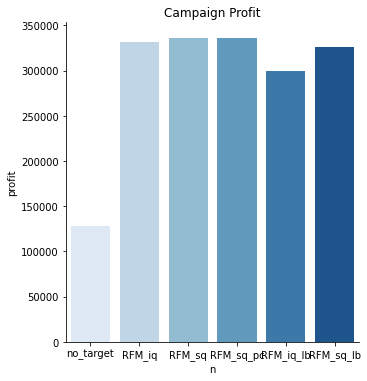

In [47]:
sns.catplot(x='n',y='profit',data=viz,kind='bar',palette="Blues").set(title='Campaign Profit')
plt.show()

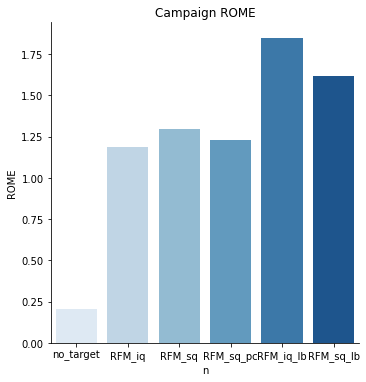

In [46]:
sns.catplot(x='n',y='ROME',data=viz,kind='bar',palette="Blues").set(title='Campaign ROME')
plt.show()



#### sequential RFM 的优点:
- 更均匀的组合 RFM 分数分布

#### sequential RFM 的缺点：
- 率和货币排名分数更难以解释。例如，新近等级为 5 的客户的频率等级为 5 可能与新近等级为 4 的客户的频率等级为 5 的含义不同，因为频率等级取决于新近等级。

#### independent RFM 的优点：
- 解释。五分位数的含义在新近、频率和货币之间是相同的。

#### independent RFM 的缺点：
- 据集较小时，更有可能生成空箱。